In [ ]:
import pandas as pd
import numpy as np
from src.dataset import StomachCancerDataset
from dataloader import build_loader
import torch
from torchvision import transforms
from torch import nn
import os
from torchvision.models.resnet import resnet152, ResNet152_Weights


classes = ['ADI',
           'DEB',
           'LYM',
           'MUC',
           'MUS',
           'NOR',
           'STR',
           'TUM']

label_mapper = {label: i for i, label in enumerate(classes)}

train_data = pd.read_csv('test.csv')
X_test = train_data['path'].values
y_test = train_data['label'].map(label_mapper).values

batch_size = 32

process_val = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = StomachCancerDataset(X_test, y_test, process_val)

test_loader = build_loader(test_dataset, batch_size, 3)

model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)



model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 2048),
                         nn.AdaptiveAvgPool1d(1024),
                         nn.BatchNorm1d(1024),
                         nn.RReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(1024, 512),
                         nn.BatchNorm1d(512),
                         nn.RReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(512, 196))

model_name = model.__class__.__name__

files = os.listdir(name := 'results/' + model_name)
number = len(files) - 1
number = 0
path = name + '/' + str(number) + '/'

csv_file = (path + 'train_stats.csv')

loss = nn.CrossEntropyLoss()

In [2]:
iterator = iter(test_loader)
inputs, labels = next(iterator)

In [3]:
classes1 = pd.read_csv('names.csv')
classes = classes1['car_names'].values
# classes

In [4]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

model

In [5]:
df = pd.read_csv(csv_file)
df

,Epoch,Train Loss,Val Loss
0,1,83.592842,76.332176
1,2,78.241176,71.999707
2,3,74.830381,68.580667
3,4,72.201714,65.846916
4,5,69.580331,63.373686
...,...,...,...
93,94,45.601862,43.920493
94,95,45.816877,44.023230
95,96,46.102970,43.613024
96,97,45.530926,44.181661


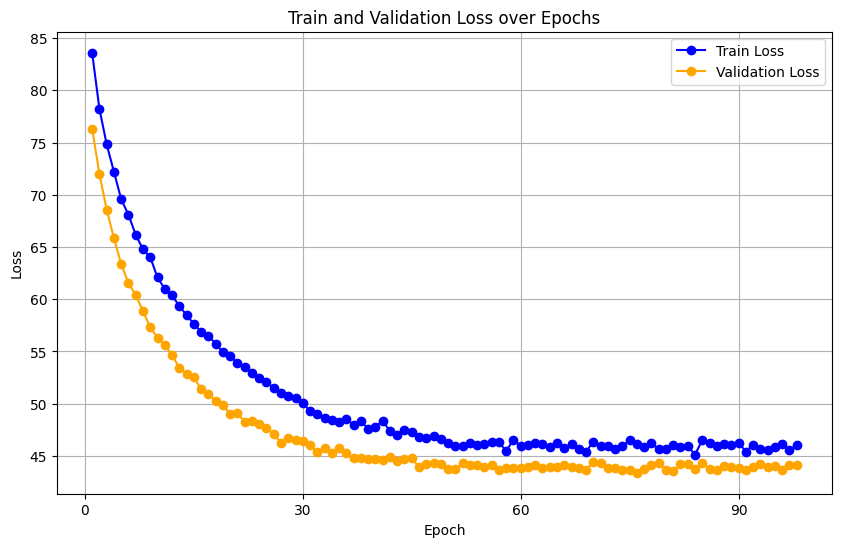

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Train Loss'], marker='o', label='Train Loss', color='blue')
plt.plot(df['Epoch'], df['Val Loss'], marker='o', label='Validation Loss', color='orange')

# Adding titles and labels
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0, max(df['Epoch']), 30))  # Set x-ticks to be the Epoch numbers
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [7]:
from torchvision import models
import torchvision

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[classes[x] for x in labels])
print(labels)

In [8]:
#model

In [ ]:
model.load_state_dict(torch.load(path + 'model.pth', weights_only=True))
model = model.cuda()

/tmp/ipykernel_1616075/553577657.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path + 'model.pth'))


model.eval()
images, labels = next(iterator)

outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)

print(predicted, labels)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(len(predicted))))

title = (' '.join('%5s |' % classes[labels[j]] for j in range(len(predicted))))
imshow(torchvision.utils.make_grid(images, normalize=False), title)



In [ ]:
model.eval()

correct = 0
total = 0
matrix = np.zeros((8, 8), dtype=int)
with torch.no_grad():    
    for images, labels in test_loader:
        
        images = images.cuda()
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        size = len(predicted)
        for i in range(size):
            matrix[labels[i].item()][predicted[i].item()] += 1

        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))



Accuracy of test images: 33.155080 %


0 ->   // 1e-5, 0.9, 0.1

1 -> 46.26 // 1e-4, 0.9, 0.3

2 -> 44.56 // 1e-5, 0.8, 0.3

3 -> 44.72 // 1e-5, 0.8, 0.5

4 -> 49.90 // 1e-4, 0.8, 0.5 

5 -> 48.34 // 1e-4, 0.8, 0.5, translation 0.3, 0.3

6-> // scheduler baseado no treino, 120 patience

7 -> 43.60 // mudança de arquitetura, 16

8 -> 48.14 // add relu, norm, 

9 -> 46.35 // 1e-4, 0.3, sp=2

10 -> 47.09 // 1e-5, 0.3, sp=2

11 -> 33.15 // resize em vez de centercrop

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()


# Set ticks and labels
classes = classes.keys()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Label the axes
plt.ylabel('True label')
plt.xlabel('Predicted label')

thresh = matrix.max() / 2.
for i, j in np.ndindex(matrix.shape):
    plt.text(j, i, format(matrix[i][j], 'd'),
             ha="center", va="center",
             color="white" if matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# 